# Hierarchical Sampling for Active Learning

based on S. Dasgupta, D. Hsu, "Hierarchical Sampling for Active Learning" (2008). ([paper](http://www.cs.columbia.edu/~djhsu/papers/hier.pdf))

In [1]:
%matplotlib inline

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import scipy.ndimage

from tqdm import tqdm

from chmp.ds import mpl_set, colorize, qplot, get_color_cycle

from chmp.app.sem_sup_img.active_learner import ActiveLearner, Clustering

In [64]:
# fit a simple sigmoid
def optimize(x, y, x0):
    res = scipy.optimize.minimize(lambda x0: -ll(x, y, x0, 1.0), x0, method='cg')
    assert res.success, res.message
    return float(res.x), -float(res.fun)
    
    
def ll(x, y, x0, w0):
    score = sigmoid(w0 * (x - x0))
    return np.mean(y * np.log(1e-6 + score) + (1 - y) * np.log(1e-6 + 1 - score))

    
def entropy(x, x0, w0):
    p = sigmoid(w0 * (x - x0))
    return -(p * np.log(1e-3 + p) + (1 - p) * np.log(1e-3 + 1 - p))
    

def sigmoid(x):
    sel = x < 0
    res = 1.0 / (1.0 + np.exp(-np.abs(x)))
    return (1 - sel) * res + sel * (1 - res)


# smoothed histograms
def smoothed_mean(x, y, bins=200, bw=1.0, range=None):
    if range is None:
        range = (np.min(x), np.max(x))
    
    x, y = np.broadcast_arrays(x, y)
    
    binned_y, _ = np.histogram(x, bins=bins, range=range, weights=y)
    binned_y = scipy.ndimage.gaussian_filter(binned_y, bw / (range[1] - range[0]) * bins)
    
    binned_x, edges = np.histogram(x, bins=bins, range=range, weights=np.ones_like(x))
    binned_x = scipy.ndimage.gaussian_filter(binned_x, bw / (range[1] - range[0]) * bins)
    
    centers = 0.5 * (edges[1:] + edges[:-1])
    return centers, binned_y / np.maximum(1, binned_x)


def smoothed_histogram(x, bins=200, bw=1.0, range=None):
    if range is None:
        range = (np.min(x), np.max(x))
    
    binned_x, edges = np.histogram(x, bins=bins, range=range, weights=np.ones_like(x))
    binned_x = scipy.ndimage.gaussian_filter(binned_x, bw / (range[1] - range[0]) * bins)
    
    centers = 0.5 * (edges[1:] + edges[:-1])
    return centers, binned_x


# plot helper for the strategy comparion
def plot_exploration(opt_x0, results, observed):
    n = min(len(results), len(observed))
    
    for i in range(0, n, 3):
        plt.scatter(
            np.random.normal(results[i, 0], 0.01 * np.ones_like(observed[i])), 
            observed[i], 
            alpha=0.005, color='b',
        )

    plt.axhline(opt_x0, ls='--', c='r')
    plt.plot(results[:n, 0], results[:n, 1], '-.g', lw=2.0)
    mpl_set(
        xlabel='Fraction of dataset explored', ylabel='Position', 
        xformatter=lambda val, _: f'{val:.0%}',
    )

## Synthetic dataset

In [18]:
n_samples = 10_000

theta = np.asarray([0.45, 0.05, 0.05, 0.45])
mu = np.asarray([0.0, 3.0, 6.0, 9.0])
p = np.asarray([0.0, 1.0, 0.5, 1.0])

cluster = np.random.choice(np.arange(4), p=theta, size=n_samples)
x = np.random.normal(loc=mu[cluster], scale=0.25)
y = np.random.binomial(1, p[cluster])

In [20]:
centers, mean_y = smoothed_mean(x, y, range=(-2, +11), bins=31, bw=0.5)
_, count_x = smoothed_histogram(x, range=(-2, +11), bins=31, bw=0.5)

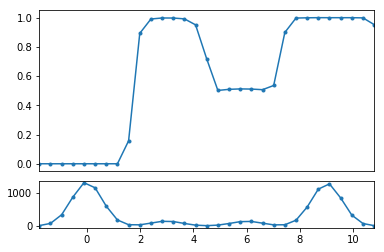

In [21]:
gs = plt.GridSpec(4, 3)

plt.subplot(gs[:-1, :])
plt.plot(centers, mean_y, marker='.')
plt.xticks([])
plt.xlim(np.min(centers), np.max(centers))

plt.subplot(gs[-1, :])
plt.plot(centers, count_x, marker='.')
plt.xlim(np.min(centers), np.max(centers))
pass

# Strategies

## Biased

In [22]:
x0 = 6.0
w0 = +1.0

selected = np.zeros_like(x, dtype=bool)
indices = np.arange(len(selected))

selected[np.random.choice(indices[cluster == 2], replace=False, size=100)] = True

biased_observed = []
biased_results = []

for step in tqdm(range(50)):
    ent = entropy(x[~selected], x0, w0)
    top = np.argsort(ent)
    top = top[-50:]
    next_idx = indices[~selected][top]
    selected[next_idx] = True

    x0, _ll = optimize(x[selected], y[selected], x0)
    biased_results.append((np.mean(selected), x0, _ll))
    biased_observed.append(np.array(x[selected]))

biased_results = np.asarray(biased_results)

100%|██████████| 50/50 [00:00<00:00, 126.14it/s]


## Random

In [23]:
selected = np.zeros_like(x, dtype=bool)
indices = np.arange(len(selected))

random_observed = []
random_results = []

for step in tqdm(range(50)):
    next_idx = np.random.choice(indices[~selected], size=50, replace=False)
    selected[next_idx] = True

    x0, _ll = optimize(x[selected], y[selected], x0)
    random_results.append((np.mean(selected), x0, _ll))
    random_observed.append(np.array(x[selected]))

random_results = np.asarray(random_results)

100%|██████████| 50/50 [00:00<00:00, 107.25it/s]


## Hierarchical Sampling

In [98]:
from chmp.ds import reload
reload('chmp.app.sem_sup_img.active_learner')
from chmp.app.sem_sup_img.active_learner import ActiveLearner, Clustering

In [99]:
learner = ActiveLearner.from_data(x, n_classes=2, concentration=1e-3)

active_results = []
active_observed = []

for step in tqdm(range(50)):
    batch = learner.propose_batch(size=50)
    
    # Note: this would be labelling procedure here
    labels = y[batch]
    
    learner.update(batch, labels)
    learner.split()
    
    active_observed.append(np.array(x[learner.observed_leaves]))
    
    y_synth = learner.get_class()
    _x0, _ll = optimize(x, y_synth, 7.0)
    active_results.append((learner.observed_leaves.mean(), _x0, _ll, len(learner.pruning)))
    
active_results = np.asarray(active_results)

100%|██████████| 50/50 [00:04<00:00, 10.03it/s]


## Comparison

In [100]:
opt_x0, _ = optimize(x, y, 7.0)

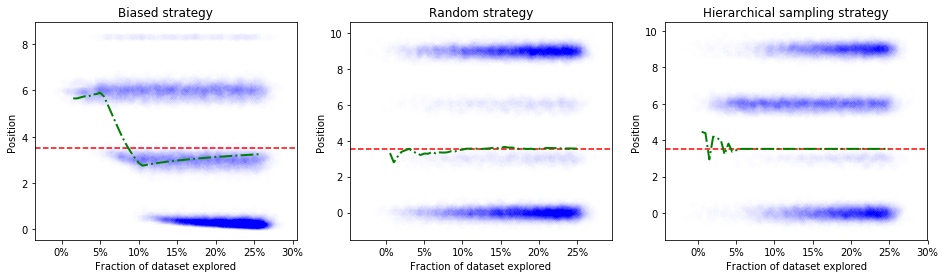

In [101]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

plt.sca(ax1)
plt.title('Biased strategy')
plot_exploration(opt_x0, biased_results, biased_observed)

plt.sca(ax2)
plt.title('Random strategy')
plot_exploration(opt_x0, random_results, random_observed)

plt.sca(ax3)
plt.title('Hierarchical sampling strategy')
plot_exploration(opt_x0, active_results, active_observed)

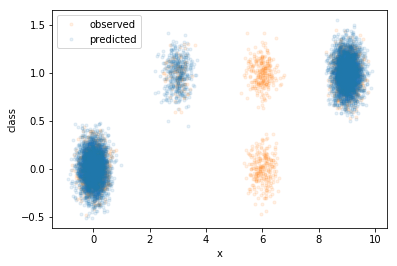

In [119]:
c0, c1 = get_color_cycle(2)

plt.plot(
    x[learner.observed_leaves], np.random.normal(y_synth[learner.observed_leaves], 0.15), 
    '.', alpha=0.1, color=c1, label='observed',
)
plt.plot(
    x[~learner.observed_leaves], np.random.normal(y_synth[~learner.observed_leaves], 0.15), 
    '.', alpha=0.1, color=c0, label='predicted',
)
mpl_set(ylabel='class', xlabel='x', legend=True)

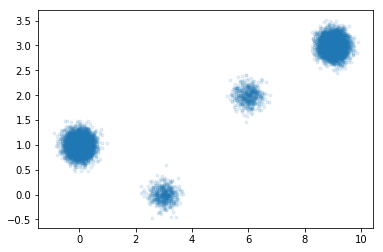

In [121]:
cluster_membership = learner.get_cluster_membership()
plt.plot(x, np.random.normal(cluster_membership, 0.15), '.', alpha=0.1)
pass

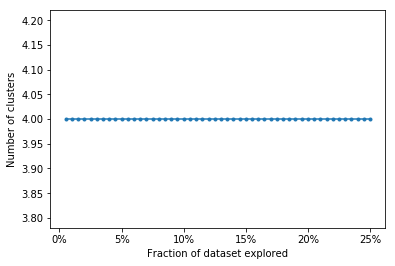

In [122]:
plt.plot(active_results[:, 0], active_results[:, -1], marker='.')
mpl_set(
    xlabel='Fraction of dataset explored', ylabel='Number of clusters', 
    xformatter=lambda val, _: f'{val:.0%}',
)

# Misc Plots

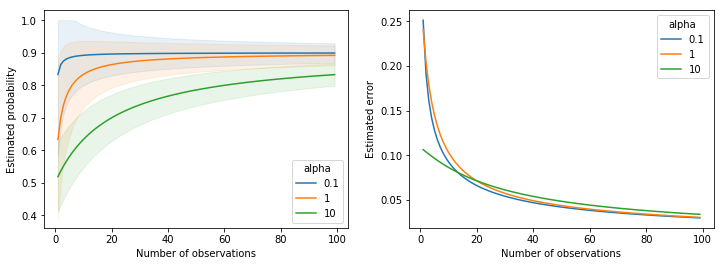

In [123]:
def compute_smoothed_proba(alpha, k, p=1.0, n_classes=2):
    alpha_i = alpha + p * k
    alpha_0 = n_classes * alpha + k
    p = alpha_i / alpha_0
    delta = np.sqrt(alpha_i * (alpha_0 - alpha_i) / (alpha_0 ** 2 * (alpha_0 + 1)))

    return p, delta


k = np.arange(1, 100)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for color, alpha in colorize([0.1, 1, 10]):
    proba, delta = compute_smoothed_proba(alpha, k, p=0.9)
    
    plt.sca(ax1)
    qplot(
        k, 
        np.vstack([np.maximum(0, proba - delta), proba, np.minimum(1, proba + delta)]), 
        label=str(alpha), color=color, fill_alpha=0.1,
    )
    
    plt.sca(ax2)
    plt.plot(k, delta, label=str(alpha), color=color)
    
mpl_set(
    ax=ax1, legend=dict(loc='best', title='alpha'), 
    xlabel='Number of observations', ylabel='Estimated probability',
)
mpl_set(
    ax=ax2, legend=dict(loc='best', title='alpha'), 
    xlabel='Number of observations', ylabel='Estimated error',
)

## Different fill strategies

In [124]:
res = []
pmax = []
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n = 5

for a in np.arange(0.1, 10, 0.3):
    p = np.random.dirichlet([a] * 3, size=100_000)
    
    pmax.append(np.mean(p.max(axis=1)))
    res.append((
        np.percentile((1 - p.max(axis=1)), q),
        np.percentile((p * (1 - p)).sum(axis=1), q)
    ))
    
res = np.asarray(res)

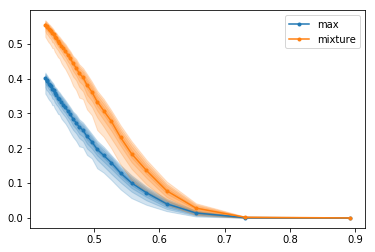

In [125]:
qplot(pmax, res[..., 0, :].T, marker='.', label='max')
qplot(pmax, res[..., 1, :].T, marker='.', label='mixture')
mpl_set(legend=True)